In [2]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [3]:
dataset = pd.read_excel('Real estate valuation data set.xlsx')

## Предварительный анализ данных

In [4]:
print("Размер датасета:", dataset.shape)
print("\nПервые 10 строк датасета:")
print(dataset.head(10))

Размер датасета: (414, 8)

Первые 10 строк датасета:
   No  X1 transaction date  X2 house age  \
0   1          2012.916667          32.0   
1   2          2012.916667          19.5   
2   3          2013.583333          13.3   
3   4          2013.500000          13.3   
4   5          2012.833333           5.0   
5   6          2012.666667           7.1   
6   7          2012.666667          34.5   
7   8          2013.416667          20.3   
8   9          2013.500000          31.7   
9  10          2013.416667          17.9   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                               10   
1                               306.59470                                9   
2                               561.98450                                5   
3                               561.98450                                5   
4                               390.56840                               

In [5]:
print("\nИнформация о датасете:")
dataset.info()


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [6]:
print("\nОсновная статистика:")
print(dataset.describe())


Основная статистика:
               No  X1 transaction date  X2 house age  \
count  414.000000           414.000000    414.000000   
mean   207.500000          2013.148953     17.712560   
std    119.655756             0.281995     11.392485   
min      1.000000          2012.666667      0.000000   
25%    104.250000          2012.916667      9.025000   
50%    207.500000          2013.166667     16.100000   
75%    310.750000          2013.416667     28.150000   
max    414.000000          2013.583333     43.800000   

       X3 distance to the nearest MRT station  \
count                              414.000000   
mean                              1083.885689   
std                               1262.109595   
min                                 23.382840   
25%                                289.324800   
50%                                492.231300   
75%                               1454.279000   
max                               6488.021000   

       X4 number of convenience

Удаляем колонку 'No', так как она не несет полезной информации для модели

In [7]:
dataset = dataset.drop('No', axis=1)

## Визуализация данных

### Тепловая карта корреляции

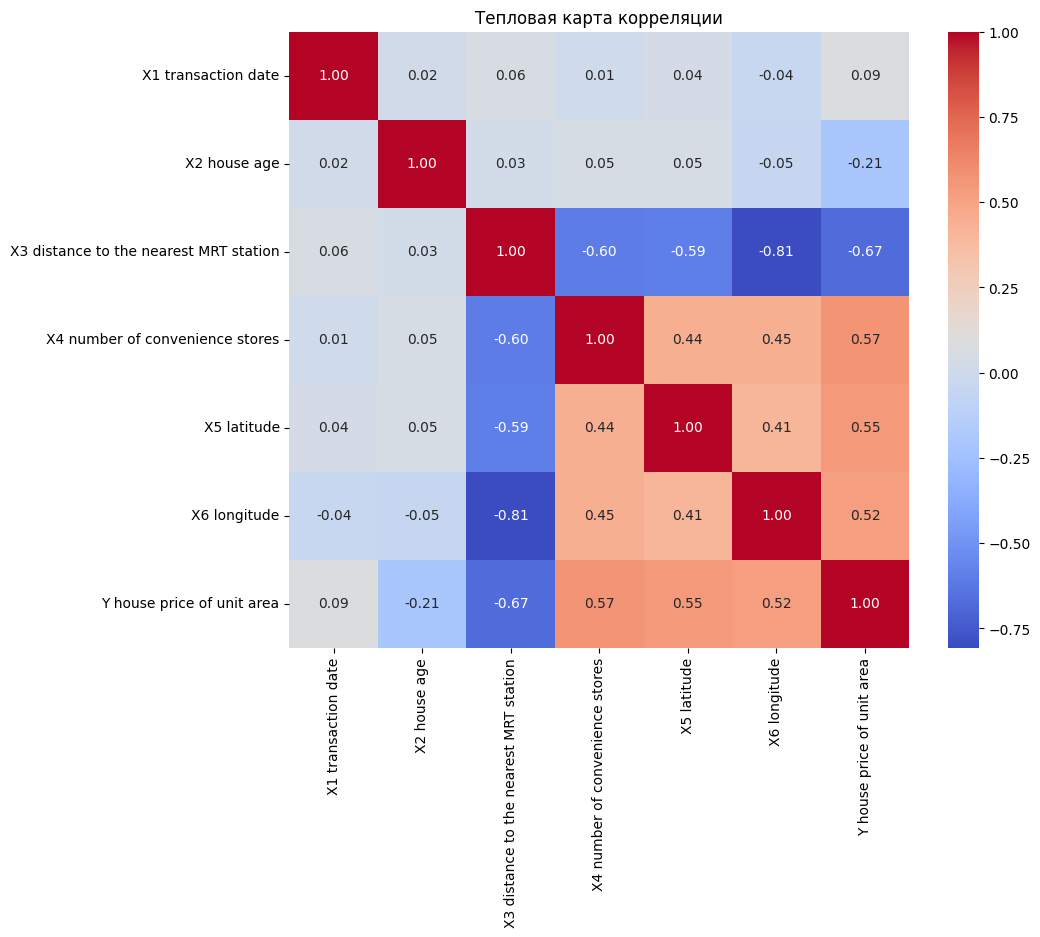

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции')
plt.show()

### Распределение целевой переменной

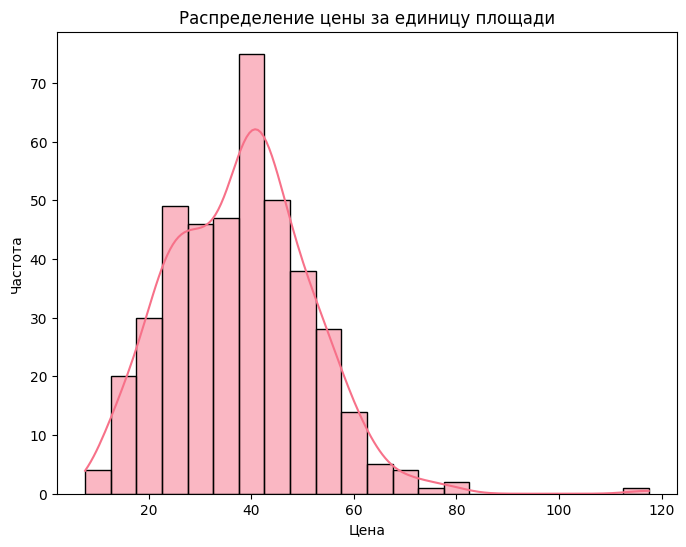

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(dataset['Y house price of unit area'], kde=True)
plt.title('Распределение цены за единицу площади')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()


### Диаграммы рассеяния для ключевых признаков

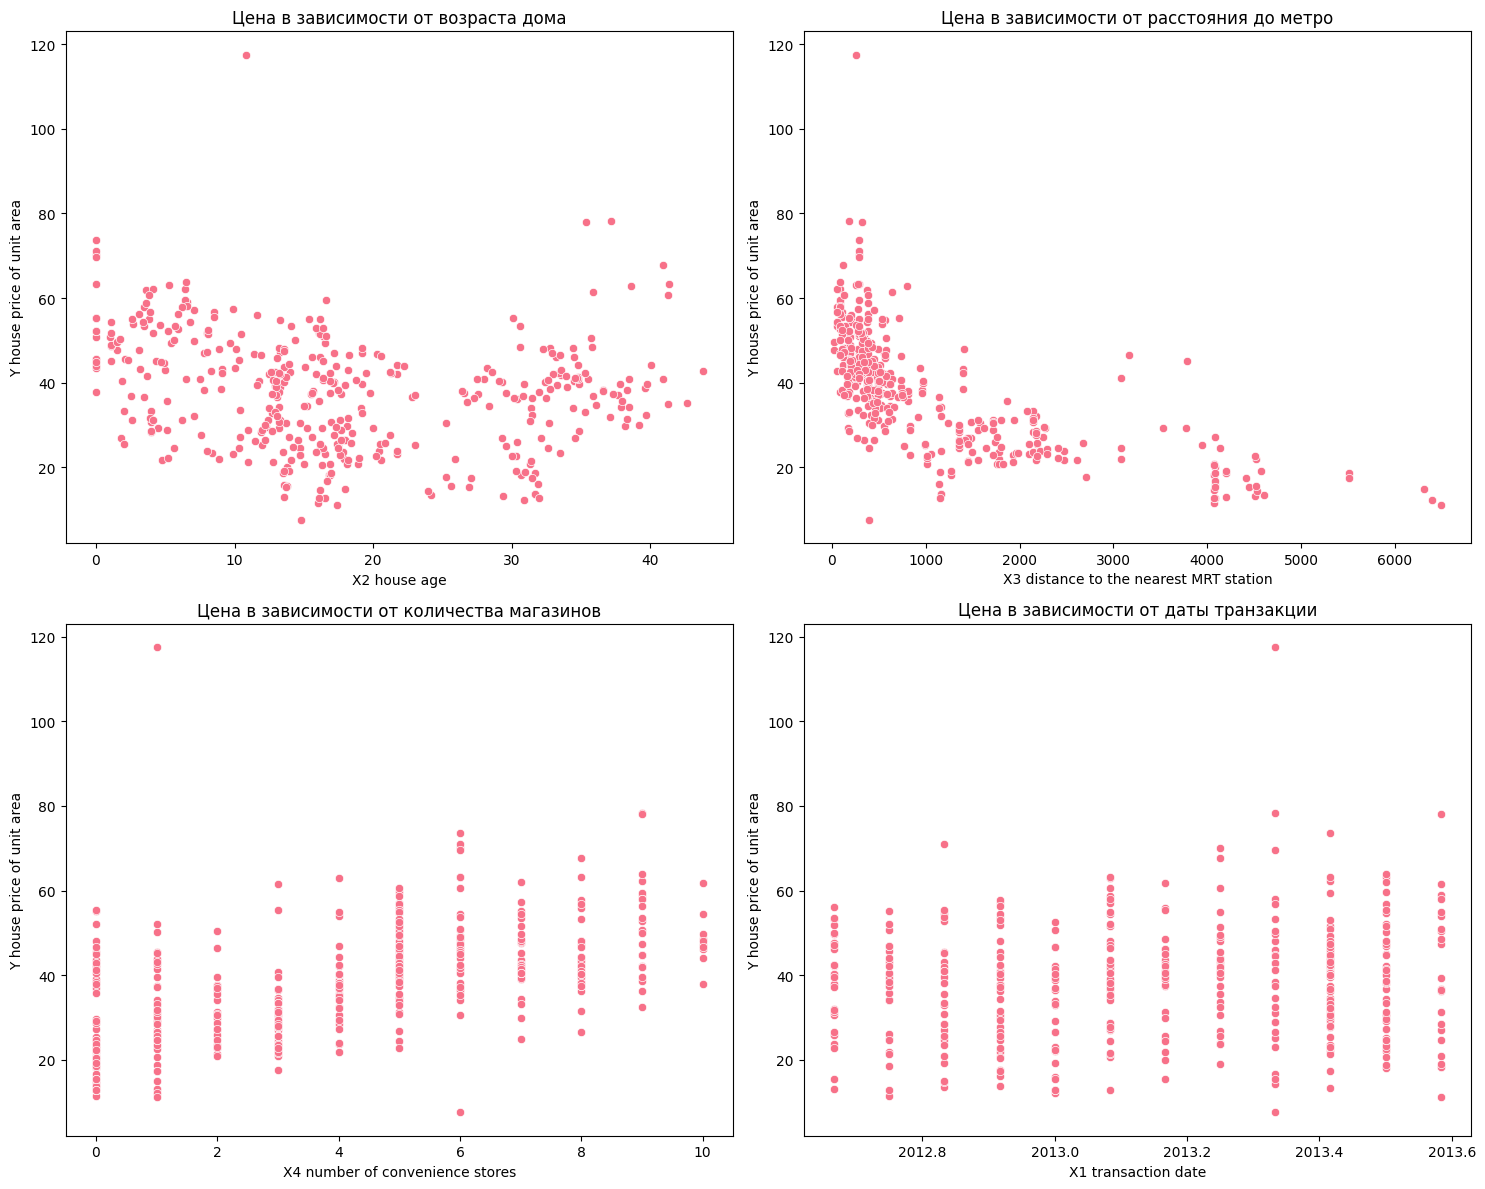

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.scatterplot(data=dataset, x='X2 house age', y='Y house price of unit area', ax=axes[0, 0])
axes[0, 0].set_title('Цена в зависимости от возраста дома')

sns.scatterplot(data=dataset, x='X3 distance to the nearest MRT station', y='Y house price of unit area', ax=axes[0, 1])
axes[0, 1].set_title('Цена в зависимости от расстояния до метро')

sns.scatterplot(data=dataset, x='X4 number of convenience stores', y='Y house price of unit area', ax=axes[1, 0])
axes[1, 0].set_title('Цена в зависимости от количества магазинов')

sns.scatterplot(data=dataset, x='X1 transaction date', y='Y house price of unit area', ax=axes[1, 1])
axes[1, 1].set_title('Цена в зависимости от даты транзакции')

plt.tight_layout()
plt.show()

## Подготовка данных для модели

### Разделяем признаки и целевую переменную

In [11]:
X = dataset.drop('Y house price of unit area', axis=1)
y = dataset['Y house price of unit area']

print(f'X shape: {X.shape} | y shape: {y.shape}')

X shape: (414, 6) | y shape: (414,)


### Разделение на обучающую и тестовую выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер обучающей выборки: (331, 6)
Размер тестовой выборки: (83, 6)


### Масштабирование данных

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Создаем список моделей для оценки

In [14]:
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge(alpha=1.0)))
models.append(('Lasso', Lasso(alpha=0.1)))
models.append(('DT', DecisionTreeRegressor(random_state=42)))
models.append(('RF', RandomForestRegressor(n_estimators=100, random_state=42)))

### Оцениваем модели с помощью кросс-валидации

In [15]:
results = []
model_names = []
print("Результаты кросс-валидации (отрицательный MSE):")
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    model_names.append(name)
    print(f'{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})')

Результаты кросс-валидации (отрицательный MSE):
LR: -87.0197 (55.5830)
Ridge: -86.9970 (55.6544)
Lasso: -86.8904 (55.7845)
DT: -111.1630 (64.8186)
RF: -66.4388 (50.9748)


### Визуализация результатов кросс-валидации

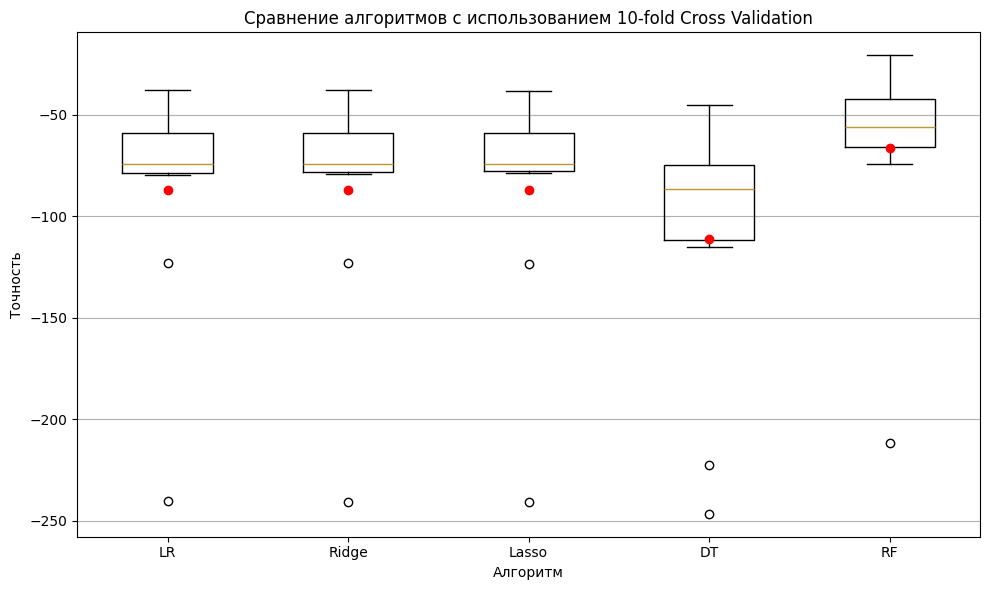

Результаты кросс-валидации:
--------------------------------------------------
LR: -87.0197 (+/- 55.5830)
Ridge: -86.9970 (+/- 55.6544)
Lasso: -86.8904 (+/- 55.7845)
DT: -111.1630 (+/- 64.8186)
RF: -66.4388 (+/- 50.9748)
--------------------------------------------------


In [16]:
# Создаем ящики с усами (boxplot) для сравнения моделей
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(results, labels=model_names)
ax.set_title('Сравнение алгоритмов с использованием 10-fold Cross Validation')
ax.set_xlabel('Алгоритм')
ax.set_ylabel('Точность')
ax.yaxis.grid(True)

# Добавляем средние значения на график
for i, result in enumerate(results):
    ax.plot(i + 1, result.mean(), 'ro')  # Красная точка для среднего значения

plt.tight_layout()
plt.show()

# Дополнительно: выводим таблицу результатов
print("Результаты кросс-валидации:")
print("-" * 50)
for name, result in zip(model_names, results):
    print(f"{name}: {result.mean():.4f} (+/- {result.std():.4f})")
print("-" * 50)


### Обучение лучшей модели (случайный лес) и оценка на тестовых данных

In [17]:
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

Предсказание на тестовых данных

In [18]:
y_pred = best_model.predict(X_test_scaled)

Оценка качества модели

In [19]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nМетрики качества на тестовой выборке:")
print(f"MSE (среднеквадратичная ошибка): {mse:.4f}")
print(f"RMSE (корень из MSE): {rmse:.4f}")
print(f"MAE (средняя абсолютная ошибка): {mae:.4f}")
print(f"R² (коэффициент детерминации): {r2:.4f}")


Метрики качества на тестовой выборке:
MSE (среднеквадратичная ошибка): 32.5371
RMSE (корень из MSE): 5.7041
MAE (средняя абсолютная ошибка): 3.9638
R² (коэффициент детерминации): 0.8060


### Визуализация предсказанных vs фактических значений

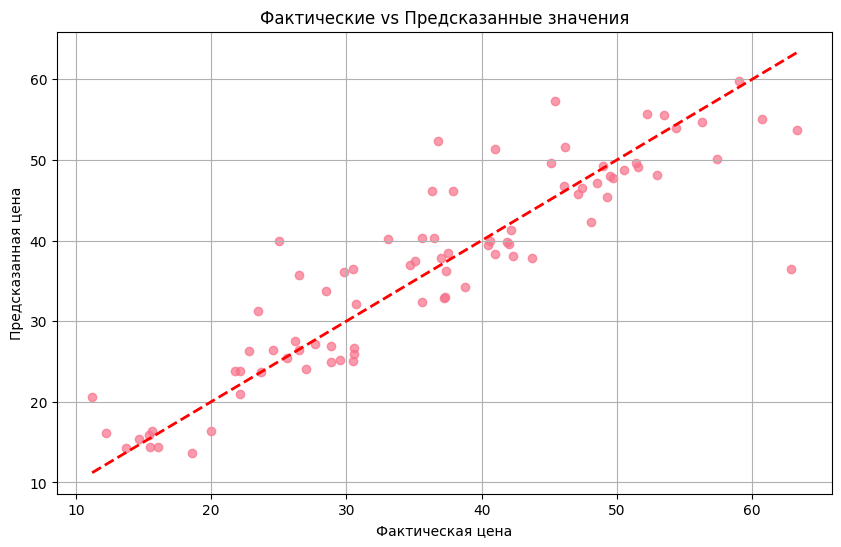

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактическая цена')
plt.ylabel('Предсказанная цена')
plt.title('Фактические vs Предсказанные значения')
plt.grid(True)
plt.show()

### Важность признаков для случайного леса

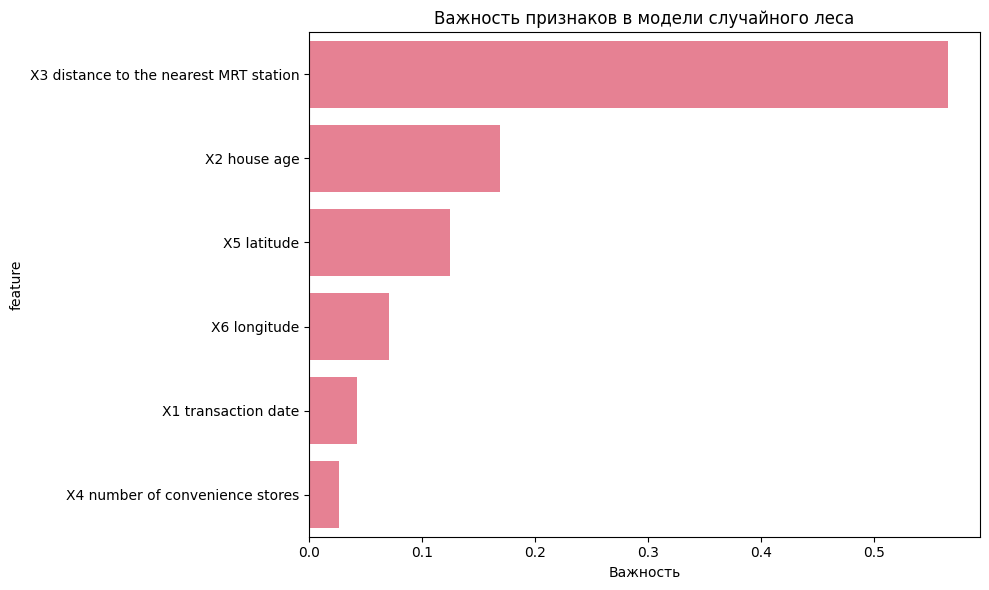

In [21]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Важность признаков в модели случайного леса')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

### Сохранение результатов в файл

In [22]:
results_df = pd.DataFrame({
    'Фактическая_цена': y_test,
    'Предсказанная_цена': y_pred,
    'Ошибка': np.abs(y_test - y_pred)
})
results_df.to_csv('real_estate_predictions.csv', index=False)
print("\nРезультаты предсказаний сохранены в файл 'real_estate_predictions.csv'")


Результаты предсказаний сохранены в файл 'real_estate_predictions.csv'
